# Homework 4
**Ziyi Guo and Neve Zhang**

In [1]:
import os
import numpy as np
import random
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Set random seed
random.seed(42)

In [2]:
# Define dataset path
root_dir = r"C:\Users\ztyuu\Desktop\Spring2025\MUSA 650\musa-650-spring-2025\musa-650-guo-zhang-submissions\EuroSAT_DeepLearning"
data_dir = f"{root_dir}/2750"
image_size = (64, 64)  # Standard resize size
class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])

## 1. Data Loading, Processing, and Exploration

### 1.1 Data Loading

In [3]:
images = []
labels = []

print("Loading images from each class...")
for class_index, class_name in enumerate(class_names):
    class_folder = os.path.join(data_dir, class_name)
    # List all image files in this class folder
    image_files = [f for f in os.listdir(class_folder) if f.endswith((".jpg", ".png"))]
    
    for img_file in image_files:
        img_path = os.path.join(class_folder, img_file)
        
        # Open and convert to RGB (to ensure consistent shape)
        with Image.open(img_path).convert("RGB") as img:
            # Convert to a NumPy array
            img_array = np.array(img)
            images.append(img_array)
            labels.append(class_index)

images = np.array(images)
labels = np.array(labels)

print(f"Total images loaded: {len(images)}")
print(f"Image array shape: {images.shape}")  # e.g., (n_samples, 64, 64, 3)

Loading images from each class...
Total images loaded: 27000
Image array shape: (27000, 64, 64, 3)


### 1.2 Data Exploration

Class 'AnnualCrop': 3000 samples
Class 'Forest': 3000 samples
Class 'HerbaceousVegetation': 3000 samples
Class 'Highway': 2500 samples
Class 'Industrial': 2500 samples
Class 'Pasture': 2000 samples
Class 'PermanentCrop': 2500 samples
Class 'Residential': 3000 samples
Class 'River': 2500 samples
Class 'SeaLake': 3000 samples


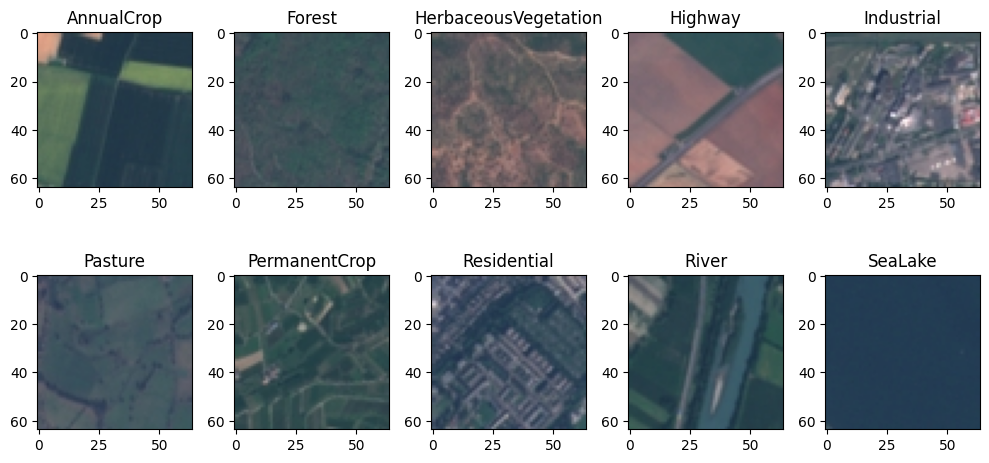

In [4]:
# Show data distribution
unique_labels, counts = np.unique(labels, return_counts=True)
for lbl, count in zip(unique_labels, counts):
    print(f"Class '{class_names[lbl]}': {count} samples")

# Show one random image from each class in a 2x5 grid
plt.figure(figsize=(10, 5))
for i, c in enumerate(np.unique(labels)): 
    plt.subplot(2, 5, i + 1)
    class_indices = np.where(labels == c)[0]

    if class_indices.size == 0:  # Check if empty
        print(f"Warning: No samples found for class {c}. Skipping...")
        continue  # Skip this iteration

    rand_idx = np.random.choice(class_indices)
    plt.imshow(images[rand_idx])
    plt.title(class_names[c])

plt.tight_layout()
plt.show()

In [55]:
# Print label-to-class mapping
print("Label to Land Use Category Mapping:")
for label in unique_labels:
    print(f"Label {label}: {class_names[label]}")

Label to Land Use Category Mapping:
Label 0: AnnualCrop
Label 1: Forest
Label 2: HerbaceousVegetation
Label 3: Highway
Label 4: Industrial
Label 5: Pasture
Label 6: PermanentCrop
Label 7: Residential
Label 8: River
Label 9: SeaLake


### 1.3 Data Augmentation

**Bonus: Before splitting the data into training and testing sets or doing any preprocessing, apply data augmentation to increase the size of the dataset, appending the new samples to the original dataset. Indicate the augmentation approach(es) that you used and the total size of the new dataset. Again, plot three random images and a histogram of the label distribution across the full dataset.**

We applied the following augmentation approaches (rotation, width shift, height shift, shear effect, and zooming up/down) to the original dataset, which doubles the sample size to 54000. This enhances sample size and to improve the model's generalizability and avoid overfitting. Then, we conducted exploratory analysis as shown below.

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,         
    width_shift_range=0.2,      
    height_shift_range=0.2,    
    shear_range=0.2,            
    zoom_range=0.2            
)

In [6]:
images_augmented = []
labels_augmented = []

num_aug_per_image = 1  

# Loop through each image in the dataset
for i in range(len(images)):
    img = images[i].reshape((1,) + images[i].shape)  # Reshape for ImageDataGenerator
    label = labels[i]

    for _ in range(num_aug_per_image):  # Generate multiple augmented versions per image
        aug_iter = datagen.flow(img, batch_size=1)  # Create augmentation iterator
        aug_img = next(aug_iter)[0].astype(np.uint8)  # Get augmented image
        images_augmented.append(aug_img)
        labels_augmented.append(label)

# Convert lists to NumPy arrays
images_augmented = np.array(images_augmented)
labels_augmented = np.array(labels_augmented)

# Combine original and augmented datasets
images_full = np.concatenate((images, images_augmented), axis=0)
labels_full = np.concatenate((labels, labels_augmented), axis=0)

# Print new dataset size
print(f"New dataset size after augmentation: {len(images_full)}")

New dataset size after augmentation: 54000


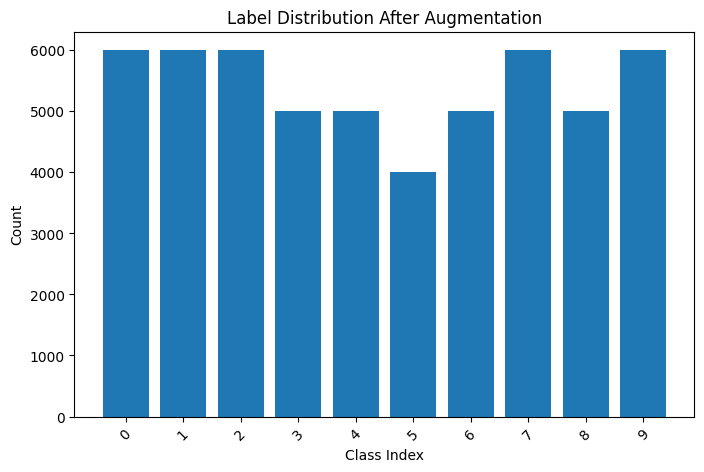

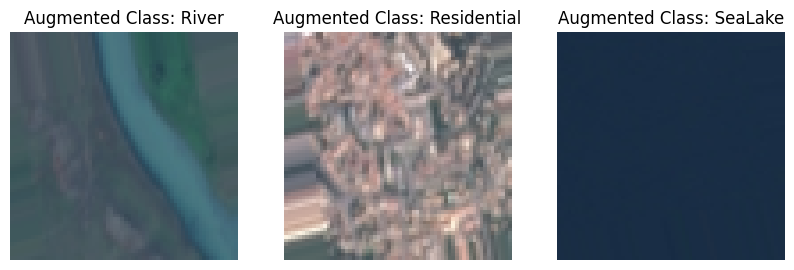

In [7]:
# Show label distribution
plt.figure(figsize=(8, 5))
plt.hist(labels_full, bins=np.arange(len(np.unique(labels_full)) + 1) - 0.5, rwidth=0.8)
plt.xticks(range(len(np.unique(labels_full))), np.unique(labels_full), rotation=45)
plt.title("Label Distribution After Augmentation")
plt.xlabel("Class Index")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(10, 3))
for i in range(3):
    idx = np.random.randint(0, len(images_augmented))
    plt.subplot(1, 3, i + 1)
    plt.imshow(images_augmented[idx])
    
    # Get class name from the class_names list using the label index
    class_name = class_names[labels_augmented[idx]]  
    
    plt.title(f"Augmented Class: {class_name}")
    plt.axis("off")
plt.show()

### 1.4 Data Flattening

While we performed data flattening to satisfy the task required, *we did not end up using the flattened RGB images since they are only involved in the CNN model development*. Essentially, the flattening process destroy spatial relationships between pixels, which are crucial for detecting edges, textures, and patterns when applying a CNN model.

In [8]:
# Flatten Images into 2D Matrix
num_samples, img_height, img_width, num_channels = images_full.shape
images_flat = images_full.reshape(num_samples, img_height * img_width * num_channels)

### 1.5 Data Splitting

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    images_flat, labels_full, test_size=0.4, stratify=labels_full, random_state=42
)

In [10]:
print(f"Flattened dataset shape: {images_flat.shape}")
print(f"Training set size: {X_train.shape}, Testing set size: {X_test.shape}")

Flattened dataset shape: (54000, 12288)
Training set size: (32400, 12288), Testing set size: (21600, 12288)


### 1.6 Create Gray-Scale Images

In [11]:
def convert_to_grayscale(image_array):
    """Convert an RGB image to grayscale using PIL."""
    img = Image.fromarray(image_array)  # Convert NumPy array to PIL Image
    img_gray = img.convert("L")  # Convert to grayscale
    return np.array(img_gray)  # Convert back to NumPy array

images_gray = np.array([convert_to_grayscale(img) for img in images_full])

We flattened the grayscale images for traditional machine learning models and fully connected neural networks.

In [12]:
# Flatten Gray-scale images
num_samples, img_height, img_width = images_gray.shape
images_gray_flat = images_gray.reshape(num_samples, img_height * img_width)

In [13]:
# Train-Test Split
X_train_gray, X_test_gray, y_train_gray, y_test_gray = train_test_split(
    images_gray_flat, labels_full, test_size=0.4, stratify=labels_full, random_state=42
)

print(f"Grayscale dataset shape: {images_gray.shape}")
print(f"Flattened grayscale dataset shape: {images_gray_flat.shape}")
print(f"Training set size: {X_train_gray.shape}, Testing set size: {X_test_gray.shape}")

Grayscale dataset shape: (54000, 64, 64)
Flattened grayscale dataset shape: (54000, 4096)
Training set size: (32400, 4096), Testing set size: (21600, 4096)


## 2. Traditional Machine-Learning

In [14]:
target_classes = ["Forest", "Residential", "Industrial"]
target_labels = [class_names.index(cls) for cls in target_classes]

# Create a boolean mask: True if y is in {Forest, Residential, Industrial}
mask = np.isin(labels_full, target_labels)

# Filter the flattened grayscale data and labels
X_3class = images_gray_flat[mask]
y_3class = labels_full[mask]

print("Filtered dataset shape:", X_3class.shape)
print("Filtered labels shape:", y_3class.shape)

Filtered dataset shape: (17000, 4096)
Filtered labels shape: (17000,)


In [15]:
# Split the filtered dataset into train/test
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(
    X_3class, 
    y_3class, 
    test_size=0.4, 
    stratify=y_3class, 
    random_state=42
)

print("3-class Training set size:", X_train_3.shape[0])
print("3-class Testing set size:", X_test_3.shape[0])

3-class Training set size: 10200
3-class Testing set size: 6800


### 2.1 Binary Support Vector Machine

In [16]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [17]:
def filter_two_classes(X, y, class_a, class_b):
    """
    Keeps only samples belonging to class_a or class_b.
    Maps class_a -> 0, class_b -> 1 for binary classification.
    """
    mask = (y == class_a) | (y == class_b)
    X_2 = X[mask]
    y_2 = y[mask].copy()
    
    # Map the labels: class_a -> 0, class_b -> 1
    y_2[y_2 == class_a] = 0
    y_2[y_2 == class_b] = 1
    return X_2, y_2

In [18]:
# Identify numeric labels for each class
forest_label = class_names.index("Forest")
residential_label = class_names.index("Residential")
industrial_label = class_names.index("Industrial")

# We'll store models and their evaluation info in dictionaries
svm_models = {}
svm_metrics = {}

Forest vs Residential

In [19]:
X_train_FR, y_train_FR = filter_two_classes(X_train_3, y_train_3, forest_label, residential_label)
X_test_FR, y_test_FR = filter_two_classes(X_test_3, y_test_3, forest_label, residential_label)

svm_FR = SVC(kernel='linear', probability=True, random_state=42)
svm_FR.fit(X_train_FR, y_train_FR)
y_pred_FR = svm_FR.predict(X_test_FR)

In [20]:
acc_FR = accuracy_score(y_test_FR, y_pred_FR)
cm_FR = confusion_matrix(y_test_FR, y_pred_FR)
report_FR = classification_report(y_test_FR, y_pred_FR)

y_prob_FR = svm_FR.predict_proba(X_test_FR)[:, 1]
fpr_FR, tpr_FR, _ = roc_curve(y_test_FR, y_prob_FR)
auc_FR = roc_auc_score(y_test_FR, y_prob_FR)

svm_models['FR'] = svm_FR
svm_metrics['FR'] = {
    'accuracy': acc_FR,
    'confusion_matrix': cm_FR,
    'classification_report': report_FR,
    'fpr': fpr_FR, 'tpr': tpr_FR, 'auc': auc_FR
}

Residential vs. Industrial

In [22]:
from sklearn.model_selection import GridSearchCV

X_train_RI, y_train_RI = filter_two_classes(X_train_3, y_train_3, residential_label, industrial_label)
X_test_RI, y_test_RI = filter_two_classes(X_test_3, y_test_3, residential_label, industrial_label)

svm_RI = SVC(kernel='linear', probability=True, random_state=42)
svm_RI = GridSearchCV(svm_RI, param_grid={}, n_jobs=-1)
svm_RI.fit(X_train_RI, y_train_RI)
y_pred_RI = svm_RI.predict(X_test_RI)

In [23]:
acc_RI = accuracy_score(y_test_RI, y_pred_RI)
cm_RI = confusion_matrix(y_test_RI, y_pred_RI)
report_RI = classification_report(y_test_RI, y_pred_RI)

y_prob_RI = svm_RI.predict_proba(X_test_RI)[:, 1]
fpr_RI, tpr_RI, _ = roc_curve(y_test_RI, y_prob_RI)
auc_RI = roc_auc_score(y_test_RI, y_prob_RI)

svm_models['RI'] = svm_RI
svm_metrics['RI'] = {
    'accuracy': acc_RI,
    'confusion_matrix': cm_RI,
    'classification_report': report_RI,
    'fpr': fpr_RI, 'tpr': tpr_RI, 'auc': auc_RI
}

Forest vs. Industrial

In [24]:
X_train_FI, y_train_FI = filter_two_classes(X_train_3, y_train_3, forest_label, industrial_label)
X_test_FI, y_test_FI = filter_two_classes(X_test_3, y_test_3, forest_label, industrial_label)

svm_FI = SVC(kernel='linear', probability=True, random_state=42)
svm_FI = GridSearchCV(svm_FI, param_grid={}, n_jobs=-1)
svm_FI.fit(X_train_FI, y_train_FI)
y_pred_FI = svm_FI.predict(X_test_FI)

In [25]:
acc_FI = accuracy_score(y_test_FI, y_pred_FI)
cm_FI = confusion_matrix(y_test_FI, y_pred_FI)
report_FI = classification_report(y_test_FI, y_pred_FI)

y_prob_FI = svm_FI.predict_proba(X_test_FI)[:, 1]
fpr_FI, tpr_FI, _ = roc_curve(y_test_FI, y_prob_FI)
auc_FI = roc_auc_score(y_test_FI, y_prob_FI)

svm_models['FI'] = svm_FI
svm_metrics['FI'] = {
    'accuracy': acc_FI,
    'confusion_matrix': cm_FI,
    'classification_report': report_FI,
    'fpr': fpr_FI, 'tpr': tpr_FI, 'auc': auc_FI
}

Print out results for each binary classifier


=== SVM FR ===
Accuracy: 0.9446
Confusion Matrix:
 [[2380   20]
 [ 246 2154]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.99      0.95      2400
           1       0.99      0.90      0.94      2400

    accuracy                           0.94      4800
   macro avg       0.95      0.94      0.94      4800
weighted avg       0.95      0.94      0.94      4800

AUC: 0.9935

=== SVM RI ===
Accuracy: 0.6798
Confusion Matrix:
 [[1666  734]
 [ 675 1325]]
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.69      0.70      2400
           1       0.64      0.66      0.65      2000

    accuracy                           0.68      4400
   macro avg       0.68      0.68      0.68      4400
weighted avg       0.68      0.68      0.68      4400

AUC: 0.7250

=== SVM FI ===
Accuracy: 0.9957
Confusion Matrix:
 [[2400    0]
 [  19 1981]]
Classification Report:
              

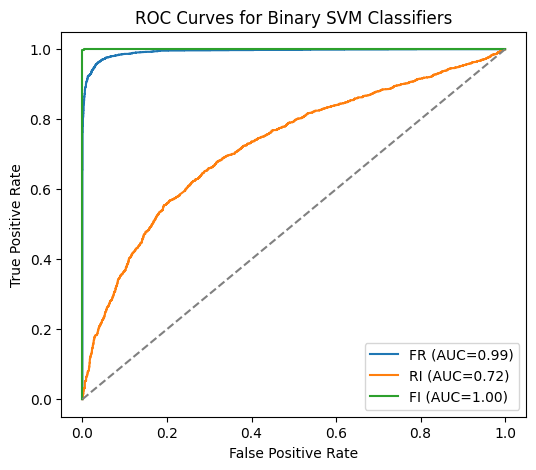

In [26]:
for pair, metrics in svm_metrics.items():
    print(f"\n=== SVM {pair} ===")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print("Confusion Matrix:\n", metrics['confusion_matrix'])
    print("Classification Report:\n", metrics['classification_report'])
    print(f"AUC: {metrics['auc']:.4f}")

# Plot ROC curves for all three
plt.figure(figsize=(6, 5))
for pair, m in svm_metrics.items():
    plt.plot(m['fpr'], m['tpr'], label=f"{pair} (AUC={m['auc']:.2f})")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Binary SVM Classifiers")
plt.legend()
plt.show()

### 2.2 Multiclass, Majority-Vote Support Vector Machine

In [27]:
from collections import Counter

def majority_vote_3classes(x, svm_FR, svm_RI, svm_FI, forest_label, residential_label, industrial_label):
    """
    For a single sample x, get votes from FR, RI, FI classifiers.
    Return the final predicted class label (forest_label, residential_label, or industrial_label).
    """
    # FR: 0 -> forest, 1 -> residential
    vote_FR = svm_FR.predict([x])[0]
    # RI: 0 -> residential, 1 -> industrial
    vote_RI = svm_RI.predict([x])[0]
    # FI: 0 -> forest, 1 -> industrial
    vote_FI = svm_FI.predict([x])[0]
    
    votes = []
    # Convert each binary vote back to the original label
    # FR
    if vote_FR == 0:
        votes.append(forest_label)
    else:
        votes.append(residential_label)
    # RI
    if vote_RI == 0:
        votes.append(residential_label)
    else:
        votes.append(industrial_label)
    # FI
    if vote_FI == 0:
        votes.append(forest_label)
    else:
        votes.append(industrial_label)
    
    # Tally the votes
    most_common = Counter(votes).most_common()
    # most_common is like [(label1, count1), (label2, count2), ...]
    # Return the label with the highest vote count
    return most_common[0][0]

# Apply majority vote to the entire 3-class test set
y_pred_mv = []
for x in X_test_3:
    pred_label = majority_vote_3classes(
        x, svm_models['FR'], svm_models['RI'], svm_models['FI'], 
        forest_label, residential_label, industrial_label
    )
    y_pred_mv.append(pred_label)

y_pred_mv = np.array(y_pred_mv)

In [28]:
# Evaluate
mv_accuracy = accuracy_score(y_test_3, y_pred_mv)
mv_cm = confusion_matrix(y_test_3, y_pred_mv, labels=target_labels)
mv_report = classification_report(y_test_3, y_pred_mv, target_names=target_classes)

print("\n=== Multiclass SVM (Majority Vote) ===")
print(f"Accuracy: {mv_accuracy:.4f}")
print("Confusion Matrix (rows=true, cols=pred):\n", mv_cm)
print("Classification Report:\n", mv_report)


=== Multiclass SVM (Majority Vote) ===
Accuracy: 0.7653
Confusion Matrix (rows=true, cols=pred):
 [[2380   20    0]
 [ 236 1504  660]
 [  14  666 1320]]
Classification Report:
               precision    recall  f1-score   support

      Forest       0.90      0.99      0.95      2400
 Residential       0.67      0.66      0.66      2000
  Industrial       0.69      0.63      0.66      2400

    accuracy                           0.77      6800
   macro avg       0.75      0.76      0.75      6800
weighted avg       0.76      0.77      0.76      6800



### 2.3 Multiclass Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier
import random

In [30]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_3, y_train_3)
y_pred_rf = rf.predict(X_test_3)

rf_accuracy = accuracy_score(y_test_3, y_pred_rf)
rf_cm = confusion_matrix(y_test_3, y_pred_rf, labels=target_labels)
rf_report = classification_report(y_test_3, y_pred_rf, target_names=target_classes)

print("\n=== Random Forest (3-class) ===")
print(f"Accuracy: {rf_accuracy:.4f}")
print("Confusion Matrix (rows=true, cols=pred):\n", rf_cm)
print("Classification Report:\n", rf_report)


=== Random Forest (3-class) ===
Accuracy: 0.9196
Confusion Matrix (rows=true, cols=pred):
 [[2357   43    0]
 [  26 2101  273]
 [   0  205 1795]]
Classification Report:
               precision    recall  f1-score   support

      Forest       0.99      0.98      0.99      2400
 Residential       0.87      0.90      0.88      2000
  Industrial       0.89      0.88      0.88      2400

    accuracy                           0.92      6800
   macro avg       0.92      0.92      0.92      6800
weighted avg       0.92      0.92      0.92      6800



In [32]:
misclassified_idx = np.where(y_pred_rf != y_test_3)[0]
if len(misclassified_idx) > 0:
    # Pick one misclassified example at random
    idx = random.choice(misclassified_idx.tolist())
    print(f"Misclassified sample index: {idx}")
    print(f"True label: {class_names[y_test_3[idx]]}, Predicted label: {class_names[y_pred_rf[idx]]}")

Misclassified sample index: 1408
True label: Residential, Predicted label: Industrial


## 3. Deep Learning

### 3.1 Greyscale Images

In [33]:
X_train_gray = X_train_gray / 255.0
X_test_gray = X_test_gray / 255.0

num_classes = 10
input_dim = X_train_gray.shape[1]

#### 3.1.1 Model One

**What kind of pre-processing might be necessary so that this model and the subsequent ones can handle categorical labels? Why?**

✅ Pre-processing is necessary to ensure the labels are in a format that the model can process correctly.

✅ There are two common approaches:

Using integer labels (0-9) with sparse_categorical_crossentropy (no encoding required).

Using one-hot encoding for labels ([0,0,0,1,0,0,0,0,0,0]) when using categorical_crossentropy.

✅ Choosing the right label format ensures proper gradient updates and improves model training consistency.

In [35]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report

In [36]:
model1 = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(num_classes, activation='softmax')
])

model1.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model1.summary()  # See the architecture

history1 = model1.fit(
    X_train_gray, y_train_gray,
    validation_split=0.2,  # 20% of training for validation
    epochs=10,
    batch_size=32,
    verbose=1
)

# Evaluate on test set
test_loss1, test_acc1 = model1.evaluate(X_test_gray, y_test_gray, verbose=0)
print(f"Model One - Test Accuracy: {test_acc1:.4f}")



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                40970     
                                                                 
Total params: 40970 (160.04 KB)
Trainable params: 40970 (160.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10


810/810 [==============================] - 5s 4ms/step - loss: 2.3594 - accuracy: 0.1433 - val_loss: 2.3710 - val_accuracy: 0.1341
Epoch 2/10
810/810 [==============================] - 3s 3ms/step - loss: 2.2881 - accuracy: 0.1802 - val_loss: 2.2743 - val_accuracy: 0.1540
Epoch 3/10
810/810 [==============================] - 2s 3ms/step - loss: 2.2352 - accuracy: 0.2056 - val_loss: 2.1790 - val_accuracy: 0.2309
Epoch 4/10
810/810 [==============================] - 3s 4ms/step - loss: 2.2001 - accuracy: 0.2225 - val_loss: 2.12

#### 3.1.2 Model Two

In [37]:
model2 = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model2.summary()

history2 = model2.fit(
    X_train_gray, y_train_gray,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    verbose=1
)

test_loss2, test_acc2 = model2.evaluate(X_test_gray, y_test_gray, verbose=0)
print(f"Model Two - Test Accuracy: {test_acc2:.4f}")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 128)               524416    
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 525706 (2.01 MB)
Trainable params: 525706 (2.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
810/810 [==============================] - 6s 7ms/step - loss: 2.2579 - accuracy: 0.1338 - val_loss: 2.1783 - val_accuracy: 0.1389
Epoch 2/10
810/810 [==============================] - 6s 8ms/step - loss: 2.1420 - accuracy: 0.2135 - val_loss: 2.0991 - val_accuracy: 0.2360
Epoch 3/10
810/810 [==============================] - 5s 6ms/step - loss: 2.0708 - accuracy: 0.2399 - val_loss: 2.0313 - val_accur

**How did adding an additional hidden layer affect your model's performance? Why might additional hidden layers improve or potentially worsen accuracy?**

#### 3.1.3 Model Three

In [38]:
model3 = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

model3.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model3.summary()

history3 = model3.fit(
    X_train_gray, y_train_gray,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    verbose=1
)

test_loss3, test_acc3 = model3.evaluate(X_test_gray, y_test_gray, verbose=0)
print(f"Model Three - Test Accuracy: {test_acc3:.4f}")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               524416    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 533322 (2.03 MB)
Trainable params: 533322 (2.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
810/810

**What did you observe about the impact of dropout layers on the model’s performance? Explain how dropout helps in model training and under what circumstances it might be more or less effective.**

#### 3.1.4 Model Comparison

In [39]:
print(f"Model One Test Accuracy:   {test_acc1:.4f}")
print(f"Model Two Test Accuracy:   {test_acc2:.4f}")
print(f"Model Three Test Accuracy: {test_acc3:.4f}")

Model One Test Accuracy:   0.2508
Model Two Test Accuracy:   0.2792
Model Three Test Accuracy: 0.1111


**Which network had the most parameters to learn, and by what margin? Which model was the "best"? Why? For each model, what is the impact of increasing the number of training epochs?**

### 3.2 RGB Images

#### 3.2.1 Model Four

Implement a fourth deep learning model, a convolution neural network (CNN) that includes the following layers: Conv2D, MaxPooling2D, Dropout, Flatten, Dense. Visualize the network architecture.

In [69]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [70]:
print(f"Full dataset shape: {images_full.shape}")
print("Unique labels:", np.unique(labels_full))

Full dataset shape: (54000, 64, 64, 3)
Unique labels: [0 1 2 3 4 5 6 7 8 9]


In [71]:
model4 = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)), 
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model4.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model4.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 16, 16, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 8, 8, 128)        

In [72]:
X_rgb_train, X_rgb_test, y_rgb_train, y_rgb_test = train_test_split(
    images_full, labels_full, test_size=0.4, random_state=42, stratify=labels_full
)

print(f"Training set size: {X_rgb_train.shape}, Testing set size: {X_rgb_test.shape}")

Training set size: (32400, 64, 64, 3), Testing set size: (21600, 64, 64, 3)


In [73]:
# Normalize pixel values
X_rgb_train = X_rgb_train / 255.0
X_rgb_test = X_rgb_test / 255.0

Calculate classification accuracy on the test data.

In [74]:
history4 = model4.fit(X_rgb_train, y_rgb_train, epochs=10, batch_size=32, validation_data=(X_rgb_test, y_rgb_test))

Epoch 1/10
1013/1013 [==============================] - 114s 111ms/step - loss: 1.2067 - accuracy: 0.5573 - val_loss: 0.8170 - val_accuracy: 0.7163
Epoch 2/10
1013/1013 [==============================] - 106s 104ms/step - loss: 0.8119 - accuracy: 0.7085 - val_loss: 0.6681 - val_accuracy: 0.7579
Epoch 3/10
1013/1013 [==============================] - 109s 108ms/step - loss: 0.6791 - accuracy: 0.7591 - val_loss: 0.6080 - val_accuracy: 0.7887
Epoch 4/10
1013/1013 [==============================] - 115s 113ms/step - loss: 0.5638 - accuracy: 0.8014 - val_loss: 0.6042 - val_accuracy: 0.7776
Epoch 5/10
1013/1013 [==============================] - 113s 112ms/step - loss: 0.4786 - accuracy: 0.8311 - val_loss: 0.4408 - val_accuracy: 0.8461
Epoch 6/10
1013/1013 [==============================] - 114s 112ms/step - loss: 0.4000 - accuracy: 0.8607 - val_loss: 0.4179 - val_accuracy: 0.8557
Epoch 7/10
1013/1013 [==============================] - 115s 113ms/step - loss: 0.3404 - accuracy: 0.8809 - val_

In [75]:
test_loss, test_acc = model4.evaluate(X_rgb_test, y_rgb_test)
print(f"\n Classification Accuracy on Test Data: {test_acc:.4f}")

675/675 [==============================] - 20s 29ms/step - loss: 0.3805 - accuracy: 0.8811

 Classification Accuracy on Test Data: 0.8811


**Compare against previous models. Which model was the "best"? Why? Did you notice any limitations in terms of training speed compared to the previous models?**

**How does the CNN model handle spatial information differently than the fully connected models? What implications does this have for image classification? Compare the training speed of CNNs with the fully connected networks. Why do CNNs generally require more computational resources?**

#### 3.2.2 Model Five

Implement a fifth deep learning model targeting accuracy that will outperform all previous models. You are free to use any tools and techniques, including ensemble models and pre-trained models for transfer learning.

In [76]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization

In [77]:
model5 = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.6),
    
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),  
    Dropout(0.5),

    Dense(10, activation='softmax') 
])

model5.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',  
              metrics=['accuracy'])

model5.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 batch_normalization_4 (Bat  (None, 64, 64, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_5 (Bat  (None, 32, 32, 64)        256       
 chNormalization)                                                
                                                      

In [78]:
history5 = model5.fit(X_rgb_train, y_rgb_train, epochs=15, batch_size=32, validation_data=(X_rgb_test, y_rgb_test))

Epoch 1/15
1013/1013 [==============================] - 179s 173ms/step - loss: 2.6524 - accuracy: 0.5345 - val_loss: 2.1039 - val_accuracy: 0.6725
Epoch 2/15
1013/1013 [==============================] - 175s 173ms/step - loss: 2.1269 - accuracy: 0.6659 - val_loss: 1.7941 - val_accuracy: 0.7488
Epoch 3/15
1013/1013 [==============================] - 175s 173ms/step - loss: 1.8718 - accuracy: 0.7188 - val_loss: 1.6101 - val_accuracy: 0.7798
Epoch 4/15
1013/1013 [==============================] - 175s 172ms/step - loss: 1.6420 - accuracy: 0.7553 - val_loss: 1.5413 - val_accuracy: 0.7643
Epoch 5/15
1013/1013 [==============================] - 176s 173ms/step - loss: 1.4223 - accuracy: 0.7862 - val_loss: 1.1887 - val_accuracy: 0.8428
Epoch 6/15
1013/1013 [==============================] - 176s 173ms/step - loss: 1.2282 - accuracy: 0.8191 - val_loss: 1.0195 - val_accuracy: 0.8595
Epoch 7/15
1013/1013 [==============================] - 170s 168ms/step - loss: 1.0553 - accuracy: 0.8463 - val_

**Calculate classification accuracy on the test data. What specific tools or techniques did you choose to improve accuracy? Why did you select these approaches over others? Compare against previous models. Which model was the "best"? Why?**

**What are the two classes with the highest labeling error? Explain using data and showing mis-classified examples. Why do you think this is? Can you think of any strategies or approaches that might help to address this issue?**

In [79]:
from sklearn.metrics import confusion_matrix

In [80]:
y_pred_probs_mod5 = model5.predict(X_rgb_test)
y_preds_mod5 = np.argmax(y_pred_probs_mod5, axis=1)

cm_mod5 = confusion_matrix(y_rgb_test, y_preds_mod5)

misclassified_idx_mod5 = np.where(y_preds_mod5 != y_rgb_test)[0]

misclass_counts_mod5 = np.bincount(y_rgb_test[misclassified_idx_mod5], minlength=10)

# two most misclassified classes
top_misclass_idx_mod5 = np.argsort(misclass_counts_mod5)[-2:]

print("\n Two most misclassified classes:")
for idx in top_misclass_idx_mod5:
    print(f"Class {idx} ({class_names[idx]}) - {misclass_counts_mod5[idx]} misclassified instances")

675/675 [==============================] - 27s 40ms/step

 Two most misclassified classes:
Class 2 (HerbaceousVegetation) - 491 misclassified instances
Class 6 (PermanentCrop) - 550 misclassified instances


### 3.3 Multispectral Images

Apply your best model on multispectral images. You may use whichever image channels you wish, so long as you use more than just RGB (although you are not required to use any color channels).

In [81]:
# Define new dataset path
data_dir_new = f"{root_dir}/EuroSAT_MS"

In [84]:
import rasterio

# Initialize lists
multispectral_images = []
multispectral_labels = []

print("Loading images from each class...")
for class_index, class_name in enumerate(class_names):
    class_folder = os.path.join(data_dir_new, class_name)
    image_files = [f for f in os.listdir(class_folder) if f.endswith(".tif")]  # Load only .tif files

    for img_file in image_files:
        img_path = os.path.join(class_folder, img_file)

        # Open multispectral image using rasterio
        with rasterio.open(img_path) as src:
            img_array = src.read()  # Read all available bands
            
            # Normalize pixel values (optional, depends on dataset)
            img_array = img_array.astype("float32") / 255.0  

        # Transpose (bands, height, width) → (height, width, bands) for CNN compatibility
        img_array = np.transpose(img_array, (1, 2, 0))

        multispectral_images.append(img_array)
        multispectral_labels.append(class_index)

# Convert lists to NumPy arrays
multispectral_images = np.array(multispectral_images)
multispectral_labels = np.array(multispectral_labels)

# Print shape to confirm number of channels
print("Multispectral image shape:", multispectral_images.shape)  # Expected: (num_samples, 64, 64, num_bands)
print("Unique labels:", np.unique(multispectral_labels))
print(f"Total multispectral images loaded: {len(multispectral_images)}")

Loading images from each class...
Multispectral image shape: (27000, 64, 64, 13)
Unique labels: [0 1 2 3 4 5 6 7 8 9]
Total multispectral images loaded: 27000


In [85]:
num_channels = multispectral_images.shape[-1]  # Automatically detect number of bands

model_multi = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, num_channels)), # Update
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Second Conv Block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),  # L2 Regularization
    Dropout(0.6),
    
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),  # Extra Dense Layer
    Dropout(0.5),

    Dense(10, activation='softmax')  
])

model_multi.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_multi.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 64, 64, 32)        3776      
                                                                 
 batch_normalization_8 (Bat  (None, 64, 64, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_9 (Bat  (None, 32, 32, 64)        256       
 chNormalization)                                                
                                                      

In [86]:
multispectral_images = multispectral_images / 255.0

In [90]:
X_multi_train, X_multi_test, y_multi_train, y_multi_test = train_test_split(
    multispectral_images, multispectral_labels, test_size=0.4, random_state=42, stratify=multispectral_labels
)

# Check sizes before training
print("X_multi_train shape:", X_multi_train.shape)
print("y_multi_train shape:", y_multi_train.shape)
print("X_multi_test shape:", X_multi_test.shape)
print("y_multi_test shape:", y_multi_test.shape)

X_multi_train shape: (16200, 64, 64, 13)
y_multi_train shape: (16200,)
X_multi_test shape: (10800, 64, 64, 13)
y_multi_test shape: (10800,)


In [93]:
history_multi = model_multi.fit(X_multi_train, y_multi_train, epochs=15, batch_size=32, validation_data=(X_multi_test, y_multi_test))

Epoch 1/15
507/507 [==============================] - 87s 171ms/step - loss: 2.1000 - accuracy: 0.7151 - val_loss: 1.7312 - val_accuracy: 0.8292
Epoch 2/15
507/507 [==============================] - 94s 185ms/step - loss: 1.8334 - accuracy: 0.7953 - val_loss: 1.6332 - val_accuracy: 0.8537
Epoch 3/15
507/507 [==============================] - 88s 173ms/step - loss: 1.6725 - accuracy: 0.8373 - val_loss: 1.6159 - val_accuracy: 0.8425
Epoch 4/15
507/507 [==============================] - 88s 173ms/step - loss: 1.5483 - accuracy: 0.8649 - val_loss: 1.5603 - val_accuracy: 0.8361
Epoch 5/15
507/507 [==============================] - 86s 170ms/step - loss: 1.4519 - accuracy: 0.8769 - val_loss: 1.3238 - val_accuracy: 0.9012
Epoch 6/15
507/507 [==============================] - 85s 169ms/step - loss: 1.3486 - accuracy: 0.8929 - val_loss: 1.3294 - val_accuracy: 0.8875
Epoch 7/15
507/507 [==============================] - 90s 177ms/step - loss: 1.2437 - accuracy: 0.9060 - val_loss: 1.1553 - val_ac

Calculate classification accuracy on the test data. Compare against results using RGB images.

In [95]:
test_loss_multi, test_acc_multi = model_multi.evaluate(X_multi_test, y_multi_test)

print(f"\n Test Accuracy on Multispectral Data: {test_acc_multi:.4f}")

338/338 [==============================] - 17s 51ms/step - loss: 0.6761 - accuracy: 0.9494

 Test Accuracy on Multispectral Data: 0.9494


**How did adding multispectral channels impact your model’s performance? Explain the role of additional spectral information in enhancing land cover classification.**

## 4. Reflection Questions

What are your takeaways from tuning the parameters of the different models? 

What are your observations about increasing the number of training epochs? 

Did you run into any challenges or limitations when doing this?

What was the impact of using dropout?

If you answered the bonus questions, how did the ensemble models compare to the other models?

 What kinds of challenges or limitations did you encounter when preparing and training the models for this assignment, and how might you address them in the future? How might you apply what you've learned about model tuning, dropout, and data processing to a different deep learning problem?